# Improving Training-Free Neural Architecture Search using NRPA and NTK

In this notebook, we design several experiments aimed at evaluating two innovative NAS methods:

- A more efficient **search algorithm**, NRPA, that leverages Monte-Carlo playouts
- A more robust **training-free metric** based on the NTK

We conduct these experiments on the following NAS benchmark datasets:
- NAS-Bench-101
- NAS-Bench-201
- NAS-Bench-301
- NATS-Bench Size

## Imports

### Importing basic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import json
from utils.helpers import configure_seaborn, normalize
import importlib
configure_seaborn()
from scipy.stats import spearmanr
import os

In [2]:
from nasbench import api  # NB101
from nas_201_api import NASBench201API as API  # NB201
# import nasbench301 as nb  # NB301
import nats_bench  # NATS

Instructions for updating:
non-resource variables are not supported in the long term


### Importing our libraries

In [3]:
# NAS-Bench-101
from search_spaces.nas_bench_101.NASBench101Node import *
from search_spaces.nas_bench_101.NASBench101MCTS import *
from search_spaces.nas_bench_101.NASBench101RandomSearch import *
from search_spaces.nas_bench_101.NASBench101RegEvo import *

# NAS-Bench-201
from search_spaces.nas_bench_201.NASBench201Node import *
from search_spaces.nas_bench_201.NASBench201MCTS import *
from search_spaces.nas_bench_201.NASBench201RandomSearch import *
from search_spaces.nas_bench_201.NASBench201RegEvo import *

# NAS-Bench-301
# from search_spaces.nas_bench_301.NASBench301Node import *
# from search_spaces.nas_bench_301.NASBench301MCTS import *
# from search_spaces.nas_bench_301.NASBench301RandomSearch import *
# from search_spaces.nas_bench_301.NASBench301RegEvo import *

# NATS-Bench
from search_spaces.nats_bench_dataset.NATSBenchNode import *
from search_spaces.nats_bench_dataset.NATSBenchMCTS import *
from search_spaces.nats_bench_dataset.NATSBenchRandomSearch import *
from search_spaces.nats_bench_dataset.NATSBenchRegEvo import *

## Evaluating the search algorithms

Creating a dictionary of datasets for evaluation. This cell can take time to run.

In [4]:
# models_1_0_dir = "API/nasbench301_models_v1.0/nb_models"
# model_paths = {
#     model_name: os.path.join(models_1_0_dir, '{}_v1.0'.format(model_name))
#     for model_name in ['xgb', 'lgb_runtime']
# }
# NB_301_performance_model = nb.load_ensemble(model_paths['xgb'])

print('Loading NB201')
nas_bench_201_api = API('api/NAS-Bench-201-v1_1-096897.pth', verbose=False)
print('Loading NB101')
nas_bench_101_api = api.NASBench("api/nasbench_full.tfrecord")
print('Loading NATS')
nats_bench_api = nats_bench.create("API/NATS-sss-v1_0-50262.pickle.pbz2", "sss", verbose=False)

Loading NB201
Loading NB101
Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 172 seconds
Loading NATS


In [5]:
datasets = {
            "nas_bench_101": {"api": nas_bench_101_api,
                              "n_runs": 100,
                              "n_iter": 3375,
                              "nrpa_level": 3,
                              "nrpa_alpha": .01},
            "nas_bench_201": {"api": nas_bench_201_api,
                              "n_runs": 100,
                              "n_iter": 200,
                              "nrpa_level": 3,
                              "nrpa_alpha": .1}, 
            # "nas_bench_301": {"api": NB_301_performance_model,
            #                   "n_runs": 100,
            #                   "n_iter": 10000,
            #                   "nrpa_level": 3,
            #                   "nrpa_alpha": 1},
            "nats_bench"   : {"api": nats_bench_api,
                              "n_runs": 100,
                              "n_iter": 400,
                              "nrpa_level": 3,
                              "nrpa_alpha": .1}
           }

### NAS-Bench-101

In [6]:
methods = {"Random search": [], 
           "Regularized evolution": [], 
           "UCT": [], 
           "NRPA": []}

params = datasets["nas_bench_101"]

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNASBench101(api=params["api"],
                                 max_iter=params["n_iter"])
    
    re = RegularizedEvolutionNB101(api=params["api"],
                                  population_size=50,
                                  cycles=params["n_iter"],
                                  sample_size=25)
    
    root_node_uct = NASBench101Node.NASBench101Node(state=NASBench101Cell(n_vertices=7))
    uct = NASBench101UCT(root_node_uct,
                         api=params["api"],
                         params_path="utils/params.json",
                         disable_tqdm=False)
    uct.n_iter = params["n_iter"]//(12*uct.playouts_per_selection)
    
    root_node_nrpa = NASBench101NestedNode(state=NASBench101Cell(n_vertices=7), sequence=[])
    nrpa = NASBench101NRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    try:
        rs.run()
        re.run()
        _, _, _ = uct.main_loop()
        _, _, _ = nrpa.main_loop()
    
        
        methods["Random search"].append(rs.best_accs[1:])
        methods["Regularized evolution"].append(re.best_accs[1:])
        methods["UCT"].append(uct.best_reward)
        methods["NRPA"].append(nrpa.best_reward)
        
    except Exception: pass

    if not os.path.isdir('runs'):
        os.mkdir('runs')
    with open("runs/NASBench101.json", "w+") as f:
        json.dump(methods, f)

RUN N° 1/100


100%|██████████| 3375/3375 [00:02<00:00, 1460.45it/s]


Best accuracy: 0.9485176205635071
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|          | 0/281 [00:00<?, ?it/s]/Users/samy/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/samy/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 281/281 [00:00<00:00, 298.20it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|██████████| 281/281 [00:00<00:00, 320.75it/s]


(5, 'build_edge', 0)


100%|██████████| 281/281 [00:00<00:00, 314.42it/s]


(6, 'build_edge', 0)


100%|██████████| 281/281 [00:00<00:00, 356.58it/s]


(3, 'build_edge', 1)


100%|██████████| 281/281 [00:00<00:00, 362.76it/s]


(2, 'build_edge', 0)


100%|██████████| 281/281 [00:00<00:00, 384.01it/s]


(5, 'build_edge', 4)


100%|██████████| 281/281 [00:00<00:00, 388.59it/s]


(4, 'build_edge', 3)


100%|██████████| 281/281 [00:00<00:00, 391.13it/s]


(4, 'build_edge', 2)


100%|██████████| 281/281 [00:00<00:00, 553.13it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|██████████| 281/281 [00:00<00:00, 799.28it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|██████████| 281/281 [00:00<00:00, 1171.83it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|██████████| 281/281 [00:00<00:00, 1533.21it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|██████████| 3375/3375 [00:14<00:00, 226.38it/s]


Sequence is [(5, 'build_edge', 3), (5, 'build_edge', 4), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 0), (3, 'build_edge', 0), (6, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 1), (2, 'set_label', 'conv1x1-bn-relu')] with score 0.9518229365348816


FileNotFoundError: [Errno 2] No such file or directory: 'runs/NASBench101.json'

In [ ]:
ma = max([len(e) for e in methods["UCT"]])
methods["UCT"] = [np.pad(e, (0,ma-len(e)), mode='maximum') for e in methods["UCT"]]

In [ ]:
max_value = max([np.max(e) for e in methods.values()])*100
min_value = min(np.quantile(e, 0.003) for e in methods.values())*100
ymax = (11*max_value - min_value) / 10

In [ ]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_101"]["n_iter"]]*100, label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nas_bench_101"]["n_iter"]/30, datasets["nas_bench_101"]["n_iter"]+(datasets["nas_bench_101"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-101")
ax.legend()
plt.tight_layout()
plt.savefig("figures/NASBench-101.png")

### NATS-Bench

In [15]:
nats_bench_df = pd.read_csv("benchmark_scores/Cifar10-NATS.csv")

In [ ]:
methods = {"Random search": [], 
           "Regularized evolution": [], 
           "UCT": [], 
           "NRPA": []}

params = datasets["nats_bench"]
params["nrpa_alpha"] = 1
params["nrpa_level"] = 3

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNats(api=params["api"],
                          df=nats_bench_df,
                          max_iter=params["n_iter"])
    
    re = RegularizedEvolutionNATS(api=params["api"],
                                  df=nats_bench_df,
                                  population_size=50,
                                  cycles=params["n_iter"],
                                  sample_size=25)
    
    root_node_uct = NATSBenchSizeNode()
    uct = NATSBenchUCT(root_node_uct,
                       api=params["api"],
                       df=nats_bench_df,
                       params_path="utils/params.json",
                       disable_tqdm=False)
    uct.n_iter = params["n_iter"]//(5*uct.playouts_per_selection)
    
    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    
    rs.run()
    re.run()
    _, _, _ = uct.main_loop()
    _, _, _ = nrpa.main_loop()

    
    methods["Random search"].append(rs.best_accs[1:])
    methods["Regularized evolution"].append(re.best_accs[1:])
    methods["UCT"].append(uct.best_reward)
    methods["NRPA"].append(nrpa.best_reward)

In [17]:
max_value = max([np.max(e) for e in methods.values()])
min_value = min(np.quantile(e, 0.005) for e in methods.values())
ymax = (11*max_value - min_value) / 10

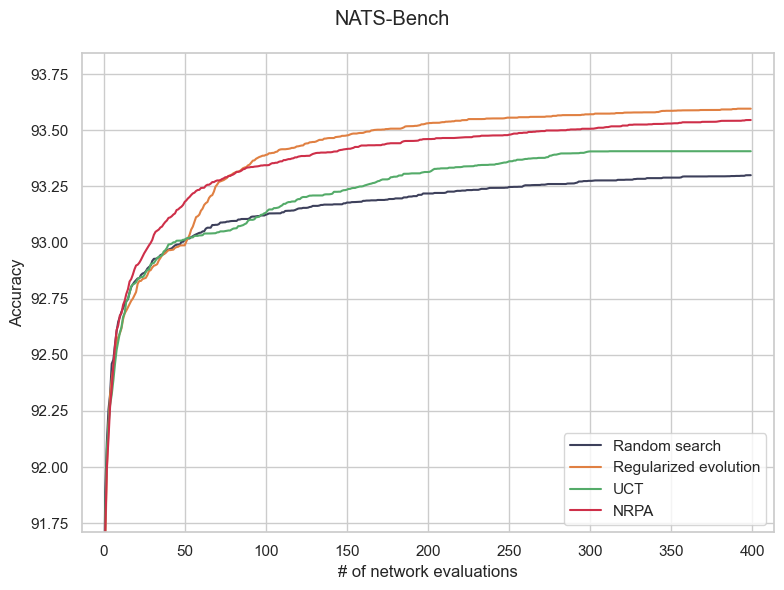

In [20]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nats_bench"]["n_iter"]], label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nats_bench"]["n_iter"]/30, datasets["nats_bench"]["n_iter"]+(datasets["nats_bench"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NATS-Bench")
ax.legend()
plt.tight_layout()
ax.legend()
if not os.path.isdir('figures'):
    os.mkdir("figures")
plt.savefig("figures/NATSBench.png")

### NAS-Bench-201

In [21]:
nas_bench_201_df = pd.read_csv("benchmark_scores/Cifar10-NB201.csv")

In [ ]:
methods = {"Random search": [], 
           "Regularized evolution": [], 
           "UCT": [],
           "NRPA": []}

params = datasets["nas_bench_201"]
params["n_iter"] = 100


for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNB201(api=params["api"],
                           df=nas_bench_201_df,
                           max_iter=params["n_iter"])
    
    re =  RegularizedEvolutionNB201(api=params["api"],
                                    df=nas_bench_201_df,
                                    population_size=50,
                                    cycles=params["n_iter"],
                                    sample_size=25)
    
    root_node_uct = NASBench201Node(state=NASBench201Cell(4))
    uct = NASBench201UCT(root_node_uct,
                         api=params["api"],
                         params_path="utils/params.json",
                         disable_tqdm=False,
                         df=nas_bench_201_df)
    uct.n_iter = params["n_iter"]//(6*uct.playouts_per_selection)
    
    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    rs.run()
    re.run()
    _, _, _ = uct.main_loop()
    _, _, _ = nrpa.main_loop()

    
    methods["Random search"].append(rs.best_accs[1:])
    methods["Regularized evolution"].append(re.best_accs[1:])
    methods["UCT"].append(uct.best_reward)
    methods["NRPA"].append(nrpa.best_reward)


In [23]:
max_value = max([np.max(e) for e in methods.values()])*100
min_value = min(np.quantile(e, 0.005) for e in methods.values())*100
ymax = (11*max_value - min_value) / 10

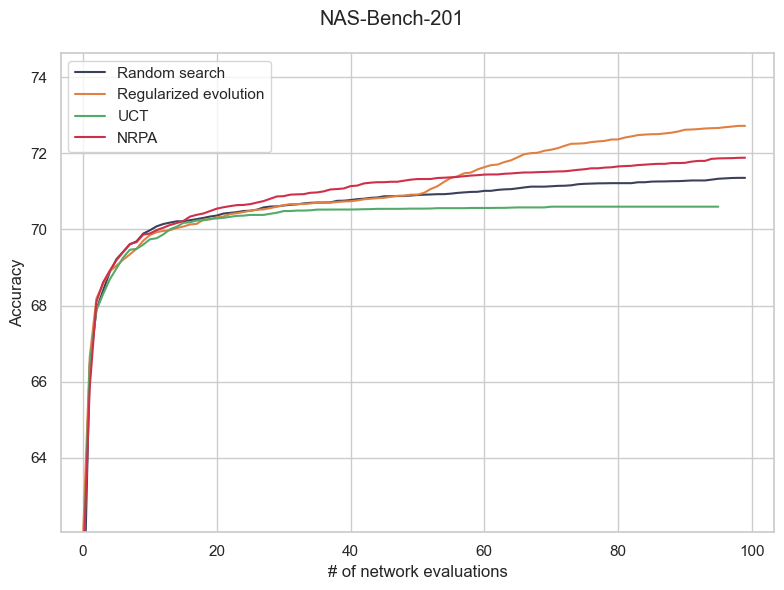

In [24]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_201"]["n_iter"]]*100, label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nas_bench_201"]["n_iter"]/30, datasets["nas_bench_201"]["n_iter"]+(datasets["nas_bench_201"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-201")
ax.legend()
plt.tight_layout()
ax.legend()
if not os.path.isdir('figures'):
    os.mkdir("figures")
plt.savefig("figures/NAS-Bench-201.png")

### NAS-Bench-301

In [ ]:
from search_spaces.nas_bench_301 import NASBench301RandomSearch
importlib.reload(NASBench301RandomSearch)
from search_spaces.nas_bench_301.NASBench301RandomSearch import *
from search_spaces.nas_bench_301 import NASBench301RegEvo
importlib.reload(NASBench301RegEvo)
from search_spaces.nas_bench_301.NASBench301RegEvo import *

In [ ]:
methods = {
           "Random search": [], 
           "Regularized evolution": [], 
           "UCT": [], 
           "NRPA": []
           }

params = datasets["nas_bench_301"]
params["n_iter"] = 100

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNB301(max_iter=params["n_iter"])
    
    re =  RegularizedEvolutionNB301(population_size=50,
                                    cycles=params["n_iter"],
                                    sample_size=25)
    
    root_node_uct = DARTSNode((DARTSCell(), DARTSCell()))
    uct = NASBench301UCT(root_node_uct,
                         performance_model=params["api"],
                         params_path="utils/params.json",
                         disable_tqdm=False)
    uct.n_iter = params["n_iter"]//(16*uct.playouts_per_selection)
    
    
    root_node_nrpa = DARTSNestedNode((DARTSCell(), DARTSCell()), sequence=[])
    nrpa = NASBench301NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           params_path="utils/params.json",
                           disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    rs.run()
    re.run()
    _, _, _ = uct.main_loop()
    _, _, _ = nrpa.main_loop()

    
    methods["Random search"].append(rs.best_accs[1:])
    methods["Regularized evolution"].append(re.best_accs[1:])
    methods["UCT"].append(uct.best_reward)
    methods["NRPA"].append(nrpa.best_reward)


In [ ]:
max_value = max([np.max(e) for e in methods.values()])
min_value = min(np.quantile(e, 0.005) for e in methods.values())
ymax = (11*max_value - min_value) /10

In [ ]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_301"]["n_iter"]], label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nas_bench_301"]["n_iter"]/30, datasets["nas_bench_301"]["n_iter"]+(datasets["nas_bench_301"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-301")
ax.legend()
plt.tight_layout()
ax.legend()

## MONET : Combining **Mo**nte-Carlo with **Ne**ural **T**angent Kernel

### On NAS-Bench-201

In [ ]:
from nas_bench_201 import NASBench201MCTS
importlib.reload(NASBench201MCTS)
from nas_bench_201.NASBench201MCTS import *

In [ ]:
nas_bench_201_df = pd.read_csv("GOOD_CSV/Cifar10-NB201.csv")

In [ ]:
params = datasets["nas_bench_201"]
accs_ntk_nb201 = []
ntks_ntk_nb201 = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.metric = "score"
    a, b, c = nrpa.main_loop()
    accs_ntk_nb201.append(nrpa.accuracies_tracker)
    ntks_ntk_nb201.append(nrpa.best_reward)

In [ ]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks_nasi), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs_nasi), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy")

plt.title("Evolution of the best architecture reward \n NTK Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-100 accuracy"); 
plt.legend();
# plt.ylim([0.56,0.62]);
plt.savefig("figures/search_nrpa_nasi_nb201.png")
plt.show()

In [ ]:
f, ax = plt.subplots(1,3, figsize=(15,5))
#MONET 
ax[0].plot(normalize(np.mean(np.array(ntks_ntk_nb201), axis=0)), label="NTK Metric", color=sns.color_palette()[0])
ax[0].set_ylabel("NTK Metric")

ax0 = ax[0].twinx()
ax0.plot(np.mean(np.array(accs_ntk_nb201), axis=0), label="Accuracy", color=sns.color_palette()[1])

# NASI
ax[1].plot(normalize(np.mean(np.array(ntks_nasi_nb201), axis=0)), label="NTK Metric", color=sns.color_palette()[0])

ax1 = ax[1].twinx()
ax1.plot(np.mean(np.array(accs_nasi_nb201), axis=0), label="Accuracy", color=sns.color_palette()[1])

# NASWOT
ax[2].plot(normalize(np.mean(np.array(ntks_synflow_nb201), axis=0)), label="NTK Metric", color=sns.color_palette()[0])

ax2 = ax[2].twinx()
ax2.plot(np.mean(np.array(accs_synflow_nb201), axis=0), label="Accuracy", color=sns.color_palette()[1])
ax2.set_ylabel("CIFAR-100 accuracy")

ax[0].set_ylabel("Training-free metric"); ax[1].set_ylabel(""), ax[2].set_ylabel(""); ax2.set_ylabel("Accuracy")
ax[0].set_title("MONET"); ax[1].set_title("NASI"); ax[2].set_title("SynFlow")

ax[0].set_xlabel("# of network evaluations"); ax[1].set_xlabel("# of network evaluations"), ax[2].set_xlabel("# of network evaluations")
ax0.set_ylim([0.71, 0.9]); ax1.set_ylim([0.71, 0.9]); ax2.set_ylim([0.71, 0.9])
# ax0.set_yticks([]); ax1.set_yticks([])
# ax[1].set_yticks([]); ax[2].set_yticks([])
f.suptitle("Training-free achitecture search - NAS-Bench-201")
plt.tight_layout()
plt.savefig("figures/search_monet_vs_gradient_nb201.png")
plt.show()

### On NATS-Bench

In [26]:
from search_spaces.nats_bench_dataset import NATSBenchMCTS
from search_spaces.nats_bench_dataset import NATSBenchNode
from search_spaces.nats_bench_dataset.NATSBenchMCTS import *
from search_spaces.nats_bench_dataset.NATSBenchNode import *

In [27]:
datasets["nats_bench"]["n_runs"]  = 100

In [28]:
nats_bench_df = pd.read_csv("benchmark_scores/Cifar10-NATS.csv")
params = datasets["nats_bench"]
accs_synflow = []
ntks_synflow = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    nrpa.metric = "score_synflow"
    a, b, c = nrpa.main_loop()
    accs_synflow.append(nrpa.accuracies_tracker)
    ntks_synflow.append(nrpa.best_reward)

Run 1 / 100


Current best reward : 0.0000:   0%|          | 1/512 [00:00<00:00, 91180.52it/s]

KeyError: 'score_synflow'

In [ ]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks_synflow), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs_synflow), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy")

plt.title("Evolution of the best architecture reward \n SynFlow Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-10 accuracy"); 
plt.legend();

plt.xlim([-20,800])
plt.savefig("figures/search_nrpa_synflow_nats.png")
plt.show()

In [ ]:
nats_bench_df = pd.read_csv("GOOD_CSV/Cifar10-NATS.csv")
params = datasets["nats_bench"]
accs_ntk = []
ntks_ntk = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    nrpa.metric = "score"
    a, b, c = nrpa.main_loop()
    accs_ntk.append(nrpa.accuracies_tracker)
    ntks_ntk.append(nrpa.best_reward)

In [ ]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks_ntk), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs_ntk), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy")

plt.title("Evolution of the best architecture reward \n NTK Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-10 accuracy"); 
plt.legend();

plt.xlim([-20,800])
plt.savefig("figures/search_nrpa_ntk_nats.png")
plt.show()

In [ ]:
nats_bench_df = pd.read_csv("GOOD_CSV/Cifar10-NATS.csv")
params = datasets["nats_bench"]
accs_nasi = []
ntks_nasi = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    nrpa.metric = "score_nasi"
    a, b, c = nrpa.main_loop()
    accs_nasi.append(nrpa.accuracies_tracker)
    ntks_nasi.append(nrpa.best_reward)

In [ ]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks_nasi), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs_nasi), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy")

plt.title("Evolution of the best architecture reward \n NTK Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-10 accuracy"); 
plt.legend();

plt.xlim([-20,800])
plt.savefig("figures/search_nrpa_nasi_nats.png")
plt.show()

In [ ]:
f, ax = plt.subplots(1,3, figsize=(15,5))
#MONET 
ax[0].plot(normalize(np.mean(np.array(ntks_ntk), axis=0)), label="NTK Metric", color=sns.color_palette()[0])
ax[0].set_ylabel("NTK Metric")

ax0 = ax[0].twinx()
ax0.plot(np.mean(np.array(accs_ntk), axis=0), label="Accuracy", color=sns.color_palette()[1])

# NASI
ax[1].plot(normalize(np.mean(np.array(ntks_nasi), axis=0)), label="NTK Metric", color=sns.color_palette()[0])

ax1 = ax[1].twinx()
ax1.plot(np.mean(np.array(accs_nasi), axis=0), label="Accuracy", color=sns.color_palette()[1])

# NASWOT
ax[2].plot(normalize(np.mean(np.array(ntks_synflow), axis=0)), label="NTK Metric", color=sns.color_palette()[0])

ax2 = ax[2].twinx()
ax2.plot(np.mean(np.array(accs_synflow), axis=0), label="Accuracy", color=sns.color_palette()[1])
ax2.set_ylabel("CIFAR-100 accuracy")

ax[0].set_ylabel("NTK Metric"); ax[1].set_ylabel(""), ax[2].set_ylabel(""); ax2.set_ylabel("Accuracy")
ax[0].set_title("MONET"); ax[1].set_title("NASI"); ax[2].set_title("SynFlow")

ax[0].set_xlabel("# of network evaluations"); ax[1].set_xlabel("# of network evaluations"), ax[2].set_xlabel("# of network evaluations")
ax0.set_ylim([90, 93.5]); ax1.set_ylim([90, 93.5]); ax2.set_ylim([90, 93.5])
# ax0.set_yticks([]); ax1.set_yticks([])
# ax[1].set_yticks([]); ax[2].set_yticks([])
f.suptitle("Training-free achitecture search - NATS")
plt.tight_layout()
plt.savefig("figures/search_monet_vs_gradient_nats.png")
plt.show()

## NRPA vs Permutation NRPA

### On NAS-Bench-201

In [29]:
class NoPermutation201NRPA(NASBench201NRPA):

    def __init__(self, root_node: NASBench201NestedNode, level, api, save_folder=None, params_path=None,
                 disable_tqdm=False, df=None):
        super().__init__(root_node, level, api, save_folder, params_path,
                 disable_tqdm, df)

    def _code(self, node, move):

        if move == None:
            ### SEULEMENT POUR LA RACINE DE L'ARBRE A PRIORI
            return node.hash

        state_code = node.hash
        code = str(state_code) 
        for i in range(len(move)):
            code = code + str(move[i])

        return code

In [30]:
methods = {"NRPA": [],
           "Permutation NRPA": []}

params = datasets["nas_bench_201"]
params["n_runs"] = 10
params["n_iter"] = 1000

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    root_node_nonrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nonrpa = NoPermutation201NRPA(root_node_nonrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nonrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nonrpa.alpha = params["nrpa_alpha"]
    
    
    _, _, _ = nrpa.main_loop()
    _, _, _ = nonrpa.main_loop()
    
    methods["NRPA"].append(nonrpa.best_reward)
    methods["Permutation NRPA"].append(nrpa.best_reward)

RUN N° 1/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 558.59it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 2, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3')] with score 0.734933333577474


Current best reward : 0.7309: 100%|██████████| 1000/1000 [00:02<00:00, 493.92it/s]


Sequence is [(3, 0, 'skip_connect'), (3, 1, 'nor_conv_1x1'), (2, 0, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 1, 'none'), (3, 2, 'nor_conv_3x3')] with score 0.7308666667073568
RUN N° 2/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 546.28it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474


Current best reward : 0.7302: 100%|██████████| 1000/1000 [00:01<00:00, 516.63it/s]


Sequence is [(2, 1, 'skip_connect'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_1x1')] with score 0.7301999998779297
RUN N° 3/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 546.54it/s]


Sequence is [(3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3')] with score 0.734933333577474


Current best reward : 0.7313: 100%|██████████| 1000/1000 [00:01<00:00, 504.59it/s]


Sequence is [(3, 0, 'skip_connect'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_1x1'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3')] with score 0.7312666664632163
RUN N° 4/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 520.96it/s]


Sequence is [(3, 0, 'skip_connect'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474


Current best reward : 0.7277: 100%|██████████| 1000/1000 [00:02<00:00, 494.10it/s]


Sequence is [(1, 0, 'nor_conv_1x1'), (2, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3')] with score 0.7277333328857423
RUN N° 5/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 539.38it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3')] with score 0.734933333577474


Current best reward : 0.7331: 100%|██████████| 1000/1000 [00:01<00:00, 500.27it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 1, 'nor_conv_1x1'), (2, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.7330666659749348
RUN N° 6/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 532.58it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 504.32it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 1, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 7/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 544.71it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474


Current best reward : 0.7253: 100%|██████████| 1000/1000 [00:01<00:00, 510.13it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'skip_connect'), (3, 2, 'nor_conv_3x3'), (2, 0, 'nor_conv_1x1')] with score 0.7252999996337891
RUN N° 8/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 549.93it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 510.79it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 9/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 517.98it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474


Current best reward : 0.7302: 100%|██████████| 1000/1000 [00:01<00:00, 530.23it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_1x1'), (1, 0, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 1, 'skip_connect')] with score 0.7301999998779297
RUN N° 10/10


Current best reward : 0.7349: 100%|██████████| 1000/1000 [00:01<00:00, 555.72it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474


Current best reward : 0.7217: 100%|██████████| 1000/1000 [00:01<00:00, 507.82it/s]

Sequence is [(3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (1, 0, 'nor_conv_1x1'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.7216999995117187


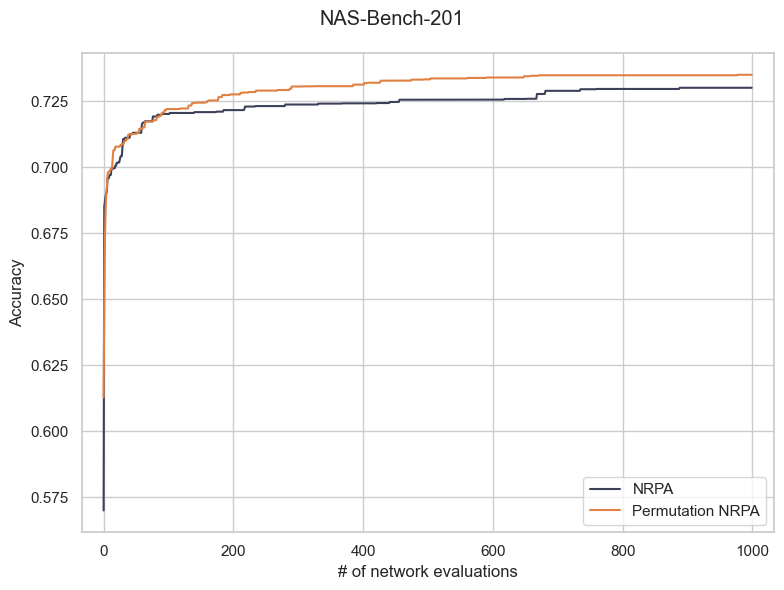

In [32]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_201"]["n_iter"]], label=name)
plt.xlim(-datasets["nas_bench_201"]["n_iter"]/30, datasets["nas_bench_201"]["n_iter"]+(datasets["nas_bench_201"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-201")
ax.legend()
plt.tight_layout()
ax.legend()
plt.savefig('figures/nrpaVSpermunrpa-nb201.png')

### On NAS-Bench-301

In [ ]:
class NoPermutation301NRPA(NASBench301NRPA):

    def __init__(self, root_node: DARTSNestedNode, level, save_folder=None, params_path=None,
                 disable_tqdm=False):
        super().__init__(root_node, level, save_folder, params_path,
                 disable_tqdm)

    def _code(self, node, move):

        if move == None:
            ### SEULEMENT POUR LA RACINE DE L'ARBRE A PRIORI
            return node.hash

        state_code = node.hash
        code = str(state_code) 
        for i in range(len(move)):
            code = code + str(move[i])

        return code

In [ ]:
methods = {"NRPA": [],
           "Permutation NRPA": []}

params = datasets["nas_bench_301"]

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    root_node_nrpa = DARTSNestedNode((DARTSCell(), DARTSCell()), sequence=[])
    nrpa = NASBench301NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           params_path="utils/params.json",
                           disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    root_node_nonrpa = DARTSNestedNode((DARTSCell(), DARTSCell()), sequence=[])
    nonrpa = NoPermutation301NRPA(root_node_nonrpa,
                           params["nrpa_level"],
                           params_path="utils/params.json",
                           disable_tqdm=False)
    nonrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nonrpa.alpha = params["nrpa_alpha"]
    
    
    _, _, _ = nrpa.main_loop()
    _, _, _ = nonrpa.main_loop()
    
    methods["NRPA"].append(nonrpa.best_reward)
    methods["Permutation NRPA"].append(nrpa.best_reward)
    

In [ ]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_201"]["n_iter"]], label=name)
plt.xlim(-datasets["nas_bench_201"]["n_iter"]/30, datasets["nas_bench_201"]["n_iter"]+(datasets["nas_bench_201"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-301")
ax.legend()
plt.tight_layout()
ax.legend()

### On NATS-Bench

In [33]:
class NoPermutationNATSNRPA(NATSBenchNRPA):

    def __init__(self, root_node: NATSBenchSizeNestedNode, level, api, save_folder=None, params_path=None,
                 disable_tqdm=False, df=None):
        super().__init__(root_node, level, api, save_folder, params_path,
                 disable_tqdm, df)

    def _code(self, node, move):

        if move == None:
            ### SEULEMENT POUR LA RACINE DE L'ARBRE A PRIORI
            return node.hash

        state_code = node.hash
        code = str(state_code) 
        for i in range(len(move)):
            code = code + str(move[i])

        return code

In [34]:
methods = {"NRPA": [],
           "Permutation NRPA": []}

params = datasets["nats_bench"]
params["n_runs"] = 20
params["n_iter"] = 1000

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    root_node_nonrpa = NATSBenchSizeNestedNode(sequence=[])
    nonrpa = NATSBenchNRPA(root_node_nonrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nonrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nonrpa.alpha = params["nrpa_alpha"]
    
    
    _, _, _ = nrpa.main_loop()
    _, _, _ = nonrpa.main_loop()
    
    methods["NRPA"].append(nonrpa.best_reward)
    methods["Permutation NRPA"].append(nrpa.best_reward)
    

RUN N° 1/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 593.10it/s]


Sequence is [(1, 64), (2, 56), (4, 24), (0, 64), (3, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 653.41it/s]


Sequence is [(0, 64), (2, 56), (4, 64), (1, 64), (3, 64)] with score 93.65
RUN N° 2/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 569.27it/s]


Sequence is [(1, 64), (3, 64), (4, 64), (2, 56), (0, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 587.06it/s]


Sequence is [(1, 64), (3, 64), (2, 56), (0, 64), (4, 64)] with score 93.65
RUN N° 3/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 588.57it/s]


Sequence is [(4, 24), (3, 64), (2, 56), (1, 64), (0, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 563.51it/s]


Sequence is [(2, 56), (1, 64), (3, 64), (0, 64), (4, 24)] with score 93.65
RUN N° 4/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 593.77it/s]


Sequence is [(2, 56), (1, 64), (0, 64), (3, 64), (4, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 587.00it/s]


Sequence is [(3, 64), (4, 64), (2, 56), (0, 64), (1, 64)] with score 93.65
RUN N° 5/20


Current best reward : 93.5100: 100%|██████████| 1000/1000 [00:01<00:00, 606.99it/s]


Sequence is [(3, 56), (0, 56), (1, 64), (2, 64), (4, 48)] with score 93.56


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 598.76it/s]


Sequence is [(0, 64), (3, 64), (4, 24), (1, 64), (2, 56)] with score 93.65
RUN N° 6/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 572.65it/s]


Sequence is [(2, 56), (1, 64), (4, 64), (3, 64), (0, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 635.20it/s]


Sequence is [(2, 56), (1, 64), (0, 64), (4, 64), (3, 64)] with score 93.65
RUN N° 7/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 619.65it/s]


Sequence is [(0, 64), (4, 64), (1, 64), (2, 56), (3, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 595.16it/s]


Sequence is [(1, 64), (3, 64), (2, 56), (0, 64), (4, 64)] with score 93.65
RUN N° 8/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 705.72it/s]


Sequence is [(2, 56), (1, 64), (4, 64), (3, 64), (0, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 654.90it/s]


Sequence is [(4, 64), (1, 64), (2, 56), (3, 64), (0, 64)] with score 93.65
RUN N° 9/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 611.59it/s]


Sequence is [(1, 64), (2, 56), (0, 64), (4, 24), (3, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 613.95it/s]


Sequence is [(0, 64), (1, 64), (4, 24), (3, 64), (2, 56)] with score 93.65
RUN N° 10/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 651.51it/s]


Sequence is [(1, 64), (2, 56), (0, 64), (4, 64), (3, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 688.30it/s]


Sequence is [(2, 56), (0, 64), (4, 64), (1, 64), (3, 64)] with score 93.65
RUN N° 11/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 698.69it/s]


Sequence is [(1, 64), (0, 64), (2, 56), (4, 64), (3, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 620.87it/s]


Sequence is [(1, 64), (0, 64), (2, 56), (4, 24), (3, 64)] with score 93.65
RUN N° 12/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 695.88it/s]


Sequence is [(4, 24), (2, 56), (0, 64), (3, 64), (1, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 691.92it/s]


Sequence is [(0, 64), (1, 64), (4, 64), (3, 64), (2, 56)] with score 93.65
RUN N° 13/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 660.09it/s]


Sequence is [(0, 64), (3, 64), (1, 64), (4, 24), (2, 56)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 675.39it/s]


Sequence is [(1, 64), (2, 56), (4, 64), (0, 64), (3, 64)] with score 93.65
RUN N° 14/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 680.71it/s]


Sequence is [(0, 64), (3, 64), (2, 56), (1, 64), (4, 64)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 677.34it/s]


Sequence is [(2, 56), (1, 64), (4, 64), (3, 64), (0, 64)] with score 93.65
RUN N° 15/20


Current best reward : 93.5300: 100%|██████████| 1000/1000 [00:01<00:00, 648.44it/s]


Sequence is [(0, 64), (2, 64), (1, 56), (4, 64), (3, 48)] with score 93.53


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 653.18it/s]


Sequence is [(1, 64), (3, 64), (2, 56), (4, 64), (0, 64)] with score 93.65
RUN N° 16/20


Current best reward : 93.5600: 100%|██████████| 1000/1000 [00:01<00:00, 642.31it/s]


Sequence is [(3, 56), (0, 56), (4, 48), (2, 64), (1, 64)] with score 93.56


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 634.50it/s]


Sequence is [(2, 56), (4, 64), (3, 64), (1, 64), (0, 64)] with score 93.65
RUN N° 17/20


Current best reward : 93.4900: 100%|██████████| 1000/1000 [00:01<00:00, 638.49it/s]


Sequence is [(3, 64), (4, 64), (1, 40), (2, 64), (0, 48)] with score 93.49


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 646.57it/s]


Sequence is [(3, 64), (2, 56), (0, 64), (4, 24), (1, 64)] with score 93.65
RUN N° 18/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 642.05it/s]


Sequence is [(0, 64), (4, 24), (1, 64), (3, 64), (2, 56)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 626.81it/s]


Sequence is [(3, 64), (1, 64), (0, 64), (2, 56), (4, 64)] with score 93.65
RUN N° 19/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 640.58it/s]


Sequence is [(3, 64), (0, 64), (4, 64), (1, 64), (2, 56)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 610.16it/s]


Sequence is [(4, 64), (1, 64), (0, 64), (2, 56), (3, 64)] with score 93.65
RUN N° 20/20


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 661.52it/s]


Sequence is [(4, 64), (0, 64), (1, 64), (3, 64), (2, 56)] with score 93.65


Current best reward : 93.6500: 100%|██████████| 1000/1000 [00:01<00:00, 628.32it/s]

Sequence is [(0, 64), (4, 24), (1, 64), (2, 56), (3, 64)] with score 93.65


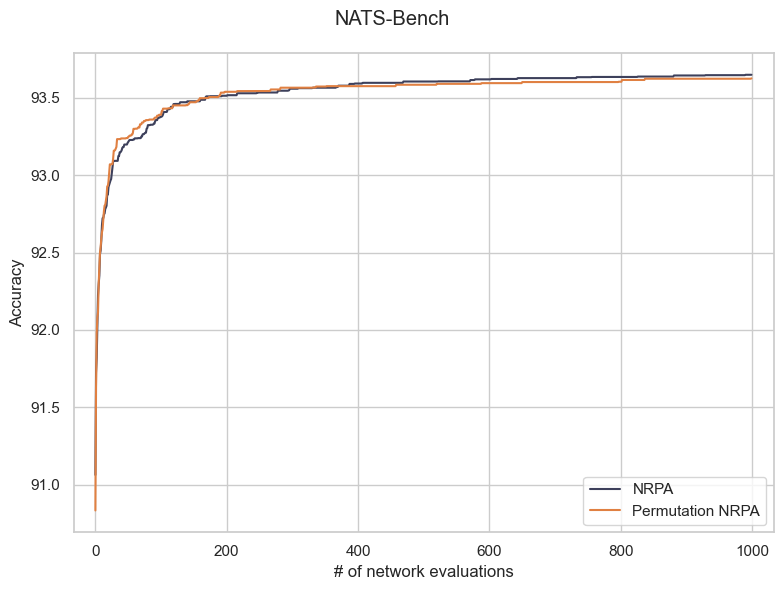

In [36]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nats_bench"]["n_iter"]], label=name)
plt.xlim(-datasets["nats_bench"]["n_iter"]/30, datasets["nats_bench"]["n_iter"]+(datasets["nats_bench"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NATS-Bench")
ax.legend()
plt.tight_layout()
ax.legend()
plt.savefig('figures/nrpaVSpermunrpa-nats.png')